In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import geoopt
import torch

In [3]:
from embedders.manifolds import Manifold, ProductManifold

In [4]:
m_h = Manifold(-1, 4)
m_h.sample([[1, 0, 0, 0, 0] * 3])

tensor([[ 1.4625,  0.2226, -0.1935,  0.4594, -0.9171],
        [ 1.3299,  0.4241, -0.5103,  0.5357, -0.2033],
        [ 1.8017,  1.2415, -0.4887,  0.6213, -0.2830]], grad_fn=<CatBackward0>)

In [5]:
m_e = Manifold(0, 4)
m_e.sample([[1, 0, 0, 0] * 3])

tensor([[-0.0938,  0.0300,  1.0028,  0.7889],
        [ 2.7113,  0.2685,  0.2466,  0.6075],
        [ 2.2942,  0.1904,  0.2349,  0.1674]], grad_fn=<AddBackward0>)

In [6]:
m_s = Manifold(1, 4)
m_s.sample([[1, 0, 0, 0, 0] * 4])

tensor([[-0.9219, -0.0666,  0.0097, -0.3670,  0.1045],
        [-0.0977, -0.9495,  0.2203, -0.1613,  0.1196],
        [-0.9999, -0.0051,  0.0019, -0.0146, -0.0036],
        [-0.9504, -0.1593,  0.0831, -0.2524,  0.0278]],
       grad_fn=<WhereBackward0>)

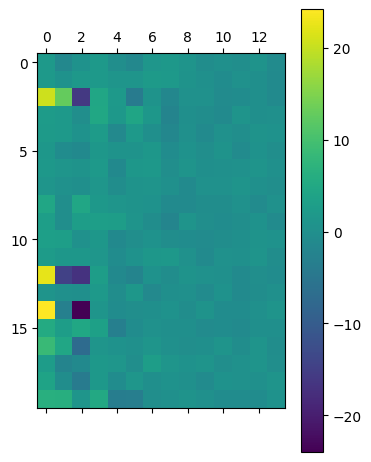

In [7]:
import matplotlib.pyplot as plt

signature = [(-2, 2), (-1, 2), (0, 2), (1, 2), (2, 2)]
pm = ProductManifold(signature)

z_sample = pm.sample([1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0] * 20)

plt.matshow(z_sample.detach().numpy().reshape(20, 14))
plt.colorbar()
plt.show()

-2
-1.0
-0.5
0
0.5
1.0
2.0


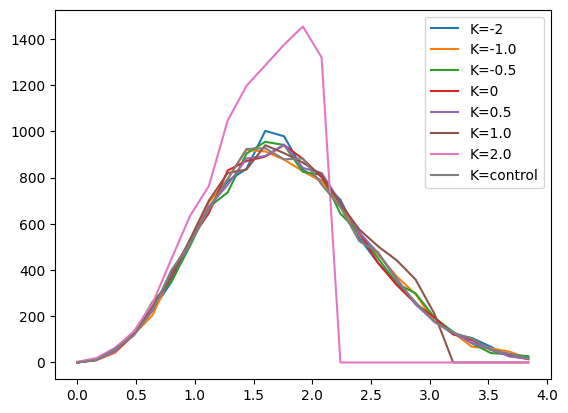

In [8]:
# Sanity check: can we get the right distribution of samples for different scales?

N_SAMPLES = 10_000

all_dists = {}
for K in [-2, -1.0, -0.5, 0, 0.5, 1.0, 2.0]:
    print(K)
    m = Manifold(K, 4)
    samples = m.sample(torch.cat([m.mu0] * N_SAMPLES, dim=0))
    dists = m.dist(m.mu0, samples)
    all_dists[K] = dists

all_dists["control"] = torch.norm(torch.randn(size=(N_SAMPLES, 4)), dim=1)

# Get histograms with torch and line-plot them
for K, dists in all_dists.items():
    dist_hist = torch.histogram(dists, bins=25, range=(0, 4))
    plt.plot(dist_hist.bin_edges[:-1].detach().cpu().numpy(), dist_hist.hist.detach().cpu().numpy(), label=f"K={K}")
plt.legend()

# Great, this looks right: all distances match, except where we totally run out of space on our manifold
# (e.g. K=2; K=1 is starting to curve off a little bit near d=pi...)